In [3]:
import re
import cv2
import time
import random
from scipy.optimize import minimize 
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error

import config as c
import utils.image_processing as ipr
import utils.model as model_factory
from scipy.optimize import minimize, rosen, rosen_der
from utils.dataset import get_train_data, get_test_data
from utils.image_processing import crop_image
from distribution_generation.distribution_generation import DistributionGenerator
from spector import get_img_spector

plt.rcParams["figure.figsize"] = (10, 10)

In [4]:
imgs, y = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(576, 576), values_linear_transformation=False, center_by_max=False)
imgs = np.array(imgs)[:,:,:,0]
y = np.array(y)[:, 1].reshape((-1, 1)).astype(np.float)

dist_gen = DistributionGenerator(imgs, y)

100%|██████████| 6646/6646 [00:00<00:00, 33735.87it/s]


In [5]:
matrix, matrix_noise = dist_gen.get_distribution(0.99, 0.06, 0.9, 21, matrix_noise=dist_gen.get_noise_img())

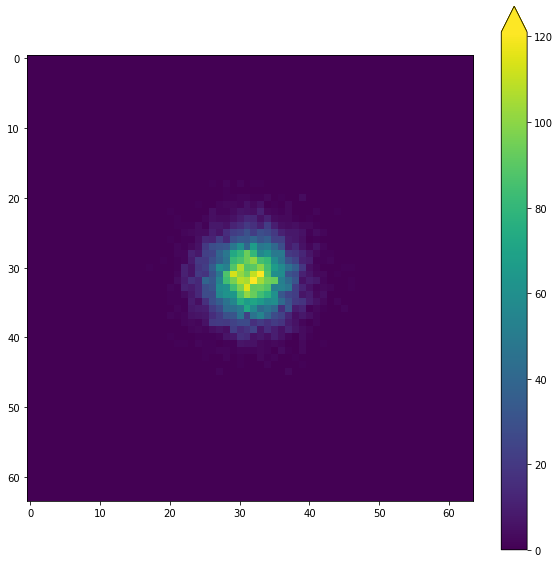

In [8]:
pos = plt.imshow(matrix)
plt.colorbar(pos, extend='max')

In [9]:
calculate_distribution_score((0.99, 0.06, 0.9, 21), imgs[(y==20).reshape(-1)], n=1000)

NameError: name 'calculate_distribution_score' is not defined

In [11]:
d = imgs[(y==6).reshape(-1)]
spectors_0 = Parallel(n_jobs=c.NUM_CORES)(delayed(get_img_spector)(crop_image(random.choice(d), (64, 64), False)) for i in range(2000))

In [52]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_matrix(img):
    m = np.zeros((16))
    for r in range(0, 16):
        mask = create_circular_mask(64, 64, radius=r) * (~create_circular_mask(64, 64, radius=r-1))
        m[r] = np.sum(mask * img) / np.sum(mask)
    return m

def get_img_spector(img):
    img = sp.ndimage.filters.gaussian_filter(img, [1.0, 1.0])
    img = get_matrix(img)
    return img

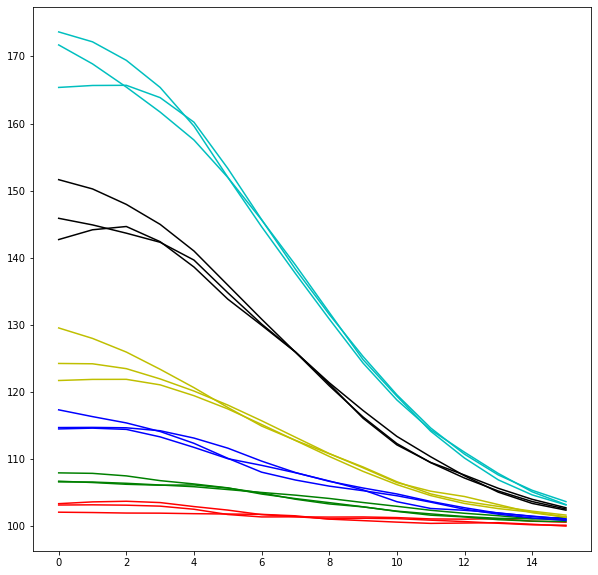

In [109]:
#plt.plot(np.sum(spectors_0, axis=0)/2000, color='g')
energys = [1, 3, 6, 10, 20, 30]
colors = ['r', 'g', 'b', 'y', 'k', 'c']
for i in range(6):
    energy = energys[i]
    color = colors[i]
    for j in range(3):
        noise = dist_gen.get_noise_img()
        spector = get_img_spector(dist_gen.get_distribution(0.99, 0.09, 0.6, energy, matrix_noise=noise)[1])
        plt.plot(spector, color=color)


#spectors_1 = Parallel(n_jobs=c.NUM_CORES)(delayed(dist_gen.get_distribution_spector)(0.99, 0.06, 0.9, 21, dist_gen.get_noise_img()) for i in range(100))
#plt.plot(np.sum(spectors_1, axis=0)/100, color='r')
plt.show()

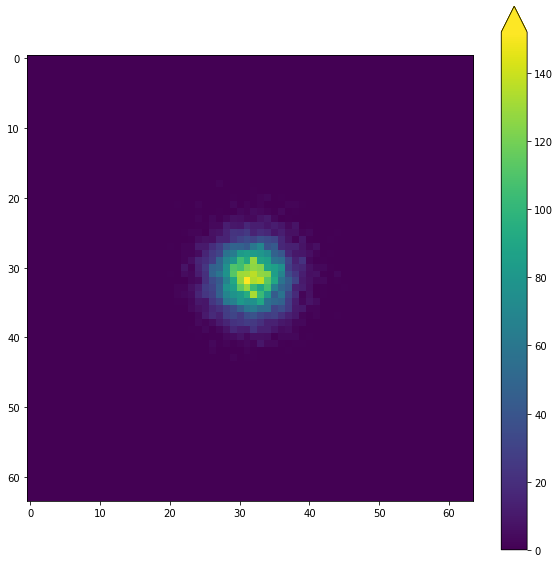

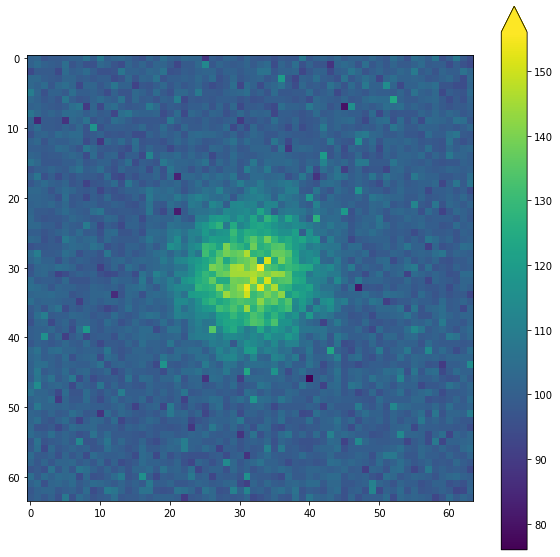

In [101]:
matrix, matrix_noise = dist_gen.get_distribution(sigma_r=0.9, average_r=0.06, p_eng=0.9, n=100000, energy_limit=21, matrix_noise=dist_gen.get_noise_img())
pos = plt.imshow(matrix)
plt.colorbar(pos, extend='max')
plt.show()

pos = plt.imshow(crop_image(random.choice(imgs[y.reshape(-1)==20]), (64, 64), False))
plt.colorbar(pos, extend='max')
plt.show()

In [34]:
get_distribution(sigma_r=0.99, average_r=0.06, p_eng=0.8, n=100000, energy_limit=21, matrix_noise=get_noise_img(100))

8388


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[103.,  99., 102., ..., 101.,  99., 101.],
        [102.,  99., 101., ...,  99.,  98., 103.],
        [ 99., 101., 100., ..., 111., 104.,  99.],
        ...,
        [ 98., 103., 102., ..., 100.,  98.,  97.],
        [ 98., 101.,  95., ...,  99.,  97., 103.],
        [102.,  97., 103., ..., 100., 103., 102.]], dtype=float32))

In [53]:
x = []
for i in range(1000):
    x.append(get_distribution(sigma_r=0.99, average_r=0.06, p_eng=0.8, n=100000, energy_limit=21, matrix_noise=get_noise_img(100))[0])
x = np.array(x)

(array([806.,   0.,   0., 160.,   0.,   0.,  27.,   0.,   0.,   7.]),
 array([10.5   , 10.5003, 10.5006, 10.5009, 10.5012, 10.5015, 10.5018,
        10.5021, 10.5024, 10.5027, 10.503 ]),
 <BarContainer object of 10 artists>)

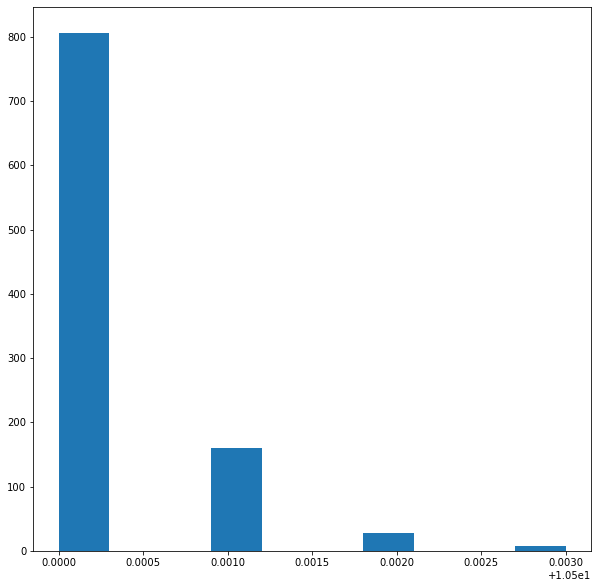

In [55]:
plt.hist((np.sum(np.sum(x, axis=1), axis=1))/1000, bins=10)

(array([  4.,  32., 145., 366., 572., 553., 343., 143.,  44.,   6.]),
 array([ 6.497    ,  7.2521   ,  8.0072   ,  8.7623005,  9.517401 ,
        10.2725   , 11.0276   , 11.782701 , 12.5378   , 13.2929   ,
        14.048    ], dtype=float32),
 <BarContainer object of 10 artists>)

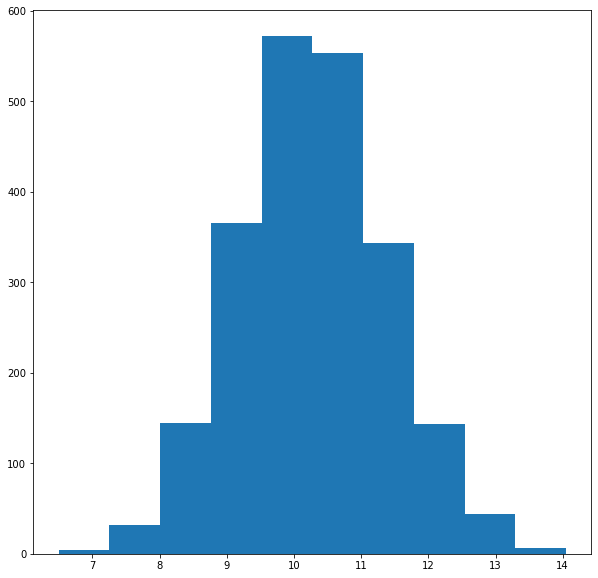

In [52]:
plt.hist((np.sum(np.sum(d[(y==20).reshape(-1)], axis=1), axis=1)-100.4*100*100)/1000)

In [50]:
d, y = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(100, 100), values_linear_transformation=False, center_by_max=False)
d = np.array(d)[:,:,:,0]
y = np.array(y)[:, 1].reshape((-1, 1)).astype(np.float)

100%|██████████| 6646/6646 [00:00<00:00, 26373.01it/s]


In [96]:
normal_distribution_0 = np.random.normal(0.0, 0.9, (10000))
normal_distribution_1 = np.random.normal(0.7, 0.999, (10000))

In [97]:
np.std(normal_distribution_0)**2+np.std(normal_distribution_1)**2

1.8060904639755053

In [98]:
np.std(normal_distribution_0+normal_distribution_1)**2

1.794337314473867